# Introduction

...

# Dataset completion

In [41]:
import pandas as pd
import numpy as np
import os
import datetime

import matplotlib.pyplot as plt
import seaborn as sns


Since the structure of the data folder is complex (some countries include multiple leagues, some not), we somehow need to iterate over all folders and all end files.

## Indexing all files

In [42]:
# We will save the root directory of the data
root_dir = "raw_data"  
file_paths = []

# Now we can walk through the directory structure
for dirpath, dirnames, filenames in os.walk(root_dir):

    # Check each file in the current directory
    for filename in filenames:

        # Filter for CSV files
        if filename.endswith(".csv"):
            file_path = os.path.join(dirpath, filename)

            # Keep track of all file paths
            file_paths.append(file_path)
            
            
# Let's look at the first file we found and see if we can load it
data = pd.read_csv(file_paths[0])
data.head()

,Div,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,...,AvgC<2.5,AHCh,B365CAHH,B365CAHA,PCAHH,PCAHA,MaxCAHH,MaxCAHA,AvgCAHH,AvgCAHA
0,B1,26/07/2019,19:30,Genk,Kortrijk,2,1,H,0,1,...,2.53,-1.25,1.98,1.88,2.01,1.88,2.05,1.96,1.96,1.87
1,B1,27/07/2019,17:00,Cercle Brugge,Standard,0,2,A,0,0,...,2.24,0.50,1.88,1.98,1.91,1.99,1.95,2.02,1.89,1.94
2,B1,27/07/2019,19:00,St Truiden,Mouscron,0,1,A,0,1,...,2.10,-0.25,1.83,2.02,1.87,2.03,1.88,2.07,1.83,2.02
3,B1,27/07/2019,19:00,Waregem,Mechelen,0,2,A,0,1,...,2.28,0.25,1.72,2.07,1.75,2.17,1.80,2.28,1.72,2.15
4,B1,27/07/2019,19:30,Waasland-Beveren,Club Brugge,1,3,A,1,1,...,2.73,1.50,2.20,1.70,2.19,1.74,2.25,1.83,2.11,1.74


## Creating the limited dataset

Ok, it looks like the walk worked and now we have a list of all paths to the csv files. Our first task here is to complete the baseline limited dataset from all files.

In [43]:
# Let's initialize an empty DataFrame to hold our limited data
limited_data = pd.DataFrame()

# Now let's create a set of features that appear in all files (we will use these later)
shared_features = set()

for file_path in file_paths:

    # Read the CSV file into a DataFrame
    temp_df = pd.read_csv(file_path)

    # Extract all feature names (column names)
    all_features = temp_df.columns.tolist()

    # Update the shared_features set with features from the current file
    shared_features.update(all_features)
    shared_features = shared_features.intersection(set(all_features))


    base_features = ["Div", "Date", "Time", "HomeTeam", "AwayTeam", "FTHG", "FTAG", "FTR"]

    # Check if temp_df contains all the base features
    if all(feature in all_features for feature in base_features):
        temp_df = temp_df[base_features]

        # Extract season from the file name and add it as a new column
        # The first split extracts the filename, the second split removes the file extension
        temp_df["Season"] = file_path.split(os.sep)[-1].split(".")[0]  
        limited_data = pd.concat([limited_data, temp_df], ignore_index=True)
    else:
        missing_features = [feature for feature in base_features if feature not in all_features]
        print(f"File: {file_path} is missing features: {missing_features}")

limited_data.shape

(42593, 9)

In [44]:
limited_data.head()

,Div,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,Season
0,B1,26/07/2019,19:30,Genk,Kortrijk,2,1,H,1920
1,B1,27/07/2019,17:00,Cercle Brugge,Standard,0,2,A,1920
2,B1,27/07/2019,19:00,St Truiden,Mouscron,0,1,A,1920
3,B1,27/07/2019,19:00,Waregem,Mechelen,0,2,A,1920
4,B1,27/07/2019,19:30,Waasland-Beveren,Club Brugge,1,3,A,1920


In [45]:
limited_data["Season"].value_counts()

Season
2122    7316
2223    7277
2324    7247
2021    7171
2425    7129
1920    6453
Name: count, dtype: int64

At some point, we will have to decide on how to encode categorical features, especially the teams. 

## Creating the full dataset

In [46]:
full_data = pd.DataFrame()

for file_path in file_paths:

    # Read the CSV file into a DataFrame
    temp_df = pd.read_csv(file_path)
    # Extract season from the file name and add it as a new column
    # The first split extracts the filename, the second split removes the file extension
    temp_df["Season"] = file_path.split(os.sep)[-1].split(".")[0] 
    
    # Extract the division name for potential future use
    division = temp_df["Div"].iloc[0]

    # Extract all feature names (column names)
    all_features = temp_df.columns.tolist()
    
    # Check if temp_df contains any extra features, other than the shared features
    if any(feature not in all_features and feature not in shared_features for feature in all_features):
        print(f"File: {file_path} has no extra features.")
    else:
        extra_features = [feature for feature in all_features if feature not in shared_features]
        print(f"File: {file_path} has extra features: {extra_features}")
    
    full_data = pd.concat([full_data, temp_df], ignore_index=True)

full_data.shape

File: raw_data\belgium\1\1920.csv has extra features: ['IWH', 'IWD', 'IWA', 'VCH', 'VCD', 'VCA', 'IWCH', 'IWCD', 'IWCA', 'VCCH', 'VCCD', 'VCCA', 'Season']
File: raw_data\belgium\1\2021.csv has extra features: ['IWH', 'IWD', 'IWA', 'VCH', 'VCD', 'VCA', 'IWCH', 'IWCD', 'IWCA', 'VCCH', 'VCCD', 'VCCA', 'Season']
File: raw_data\belgium\1\2122.csv has extra features: ['IWH', 'IWD', 'IWA', 'VCH', 'VCD', 'VCA', 'IWCH', 'IWCD', 'IWCA', 'VCCH', 'VCCD', 'VCCA', 'Unnamed: 105', 'Season']
File: raw_data\belgium\1\2223.csv has extra features: ['IWH', 'IWD', 'IWA', 'VCH', 'VCD', 'VCA', 'IWCH', 'IWCD', 'IWCA', 'VCCH', 'VCCD', 'VCCA', 'Season']
File: raw_data\belgium\1\2324.csv has extra features: ['IWH', 'IWD', 'IWA', 'VCH', 'VCD', 'VCA', 'IWCH', 'IWCD', 'IWCA', 'VCCH', 'VCCD', 'VCCA', 'Season']
File: raw_data\belgium\1\2425.csv has extra features: ['Unnamed: 119', 'Unnamed: 120', 'Season']
File: raw_data\england\0\1920.csv has extra features: ['Referee', 'IWH', 'IWD', 'IWA', 'VCH', 'VCD', 'VCA', 'IWC

(42593, 138)

# Dataset cleaning

## Fixing NA'S

In [47]:
print(full_data.columns.tolist())

['Div', 'Date', 'Time', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'HTHG', 'HTAG', 'HTR', 'HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HC', 'AC', 'HY', 'AY', 'HR', 'AR', 'B365H', 'B365D', 'B365A', 'BWH', 'BWD', 'BWA', 'IWH', 'IWD', 'IWA', 'PSH', 'PSD', 'PSA', 'WHH', 'WHD', 'WHA', 'VCH', 'VCD', 'VCA', 'MaxH', 'MaxD', 'MaxA', 'AvgH', 'AvgD', 'AvgA', 'B365>2.5', 'B365<2.5', 'P>2.5', 'P<2.5', 'Max>2.5', 'Max<2.5', 'Avg>2.5', 'Avg<2.5', 'AHh', 'B365AHH', 'B365AHA', 'PAHH', 'PAHA', 'MaxAHH', 'MaxAHA', 'AvgAHH', 'AvgAHA', 'B365CH', 'B365CD', 'B365CA', 'BWCH', 'BWCD', 'BWCA', 'IWCH', 'IWCD', 'IWCA', 'PSCH', 'PSCD', 'PSCA', 'WHCH', 'WHCD', 'WHCA', 'VCCH', 'VCCD', 'VCCA', 'MaxCH', 'MaxCD', 'MaxCA', 'AvgCH', 'AvgCD', 'AvgCA', 'B365C>2.5', 'B365C<2.5', 'PC>2.5', 'PC<2.5', 'MaxC>2.5', 'MaxC<2.5', 'AvgC>2.5', 'AvgC<2.5', 'AHCh', 'B365CAHH', 'B365CAHA', 'PCAHH', 'PCAHA', 'MaxCAHH', 'MaxCAHA', 'AvgCAHH', 'AvgCAHA', 'Season', 'Unnamed: 105', 'BFH', 'BFD', 'BFA', '1XBH', '1XBD', '1XBA', 'BFEH', 'BFED', 'B

In [48]:
unnameds = [col for col in full_data.columns if "Unnamed" in col]
for col in unnameds:
    print(full_data[col].unique())

[nan]
[nan]
[nan]
[nan]
[nan]


In [49]:
full_data = full_data.drop(columns=unnameds)

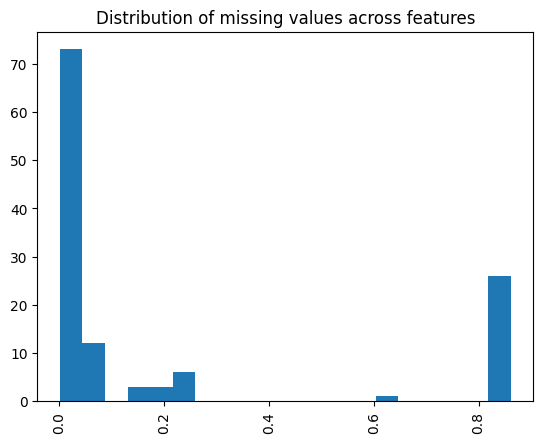

In [50]:
# Count the proportion of missing values for each feature
na_sums = full_data.isnull().sum().sort_values(ascending=False)/full_data.shape[0]

# Plot a simple histohgram of the missing value proportions
plt.hist(x=na_sums[na_sums > 0],bins=20)
plt.xticks(rotation=90)
plt.title("Distribution of missing values across features")
plt.show()

C:\Users\brzak\AppData\Local\Temp\ipykernel_21524\2112083874.py:5: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda df: df.isnull().mean())


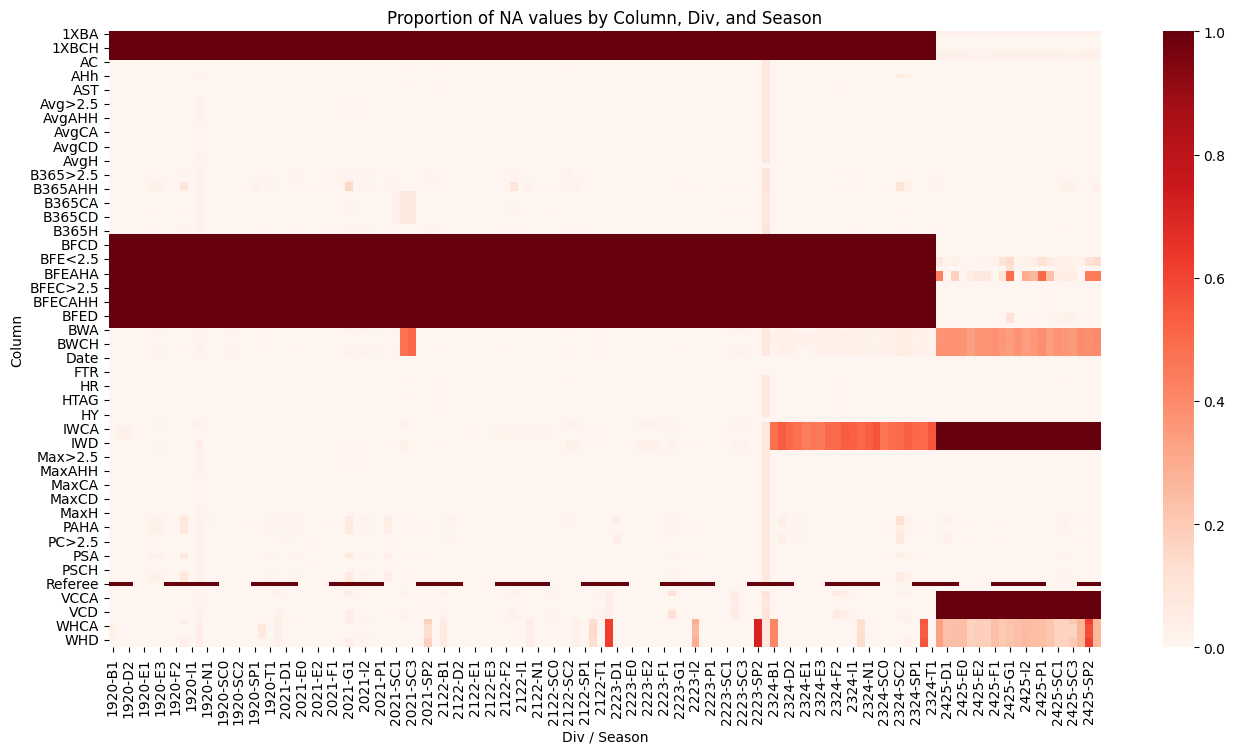

In [57]:
# Calculate NA proportions for each column, grouped by Div and Season
na_by_group = (
    full_data
    .groupby(['Season','Div'])
    .apply(lambda df: df.isnull().mean())
    .reset_index(drop=True)
)

# Add Div and Season back as columns for melting
na_by_group['Season'] = full_data.groupby(['Season','Div']).groups.keys()
na_by_group[['Season','Div']] = pd.DataFrame(na_by_group['Season'].tolist(), index=na_by_group.index)

# Melt the dataframe for easier plotting
na_melted = na_by_group.melt(id_vars=['Season','Div'], var_name='Column', value_name='NA_Ratio')

# Pivot for heatmap: rows=Column, columns=Div_Season, values=NA_Ratio
na_pivot = na_melted.pivot_table(
    index='Column',
    columns=['Season','Div'],
    values='NA_Ratio',
    fill_value=0
)

plt.figure(figsize=(16, 8))
sns.heatmap(na_pivot, annot=False, cmap="Reds")
plt.title("Proportion of NA values by Column, Div, and Season")
plt.ylabel("Column")
plt.xlabel("Div / Season")
plt.show()

## Correlation analysis

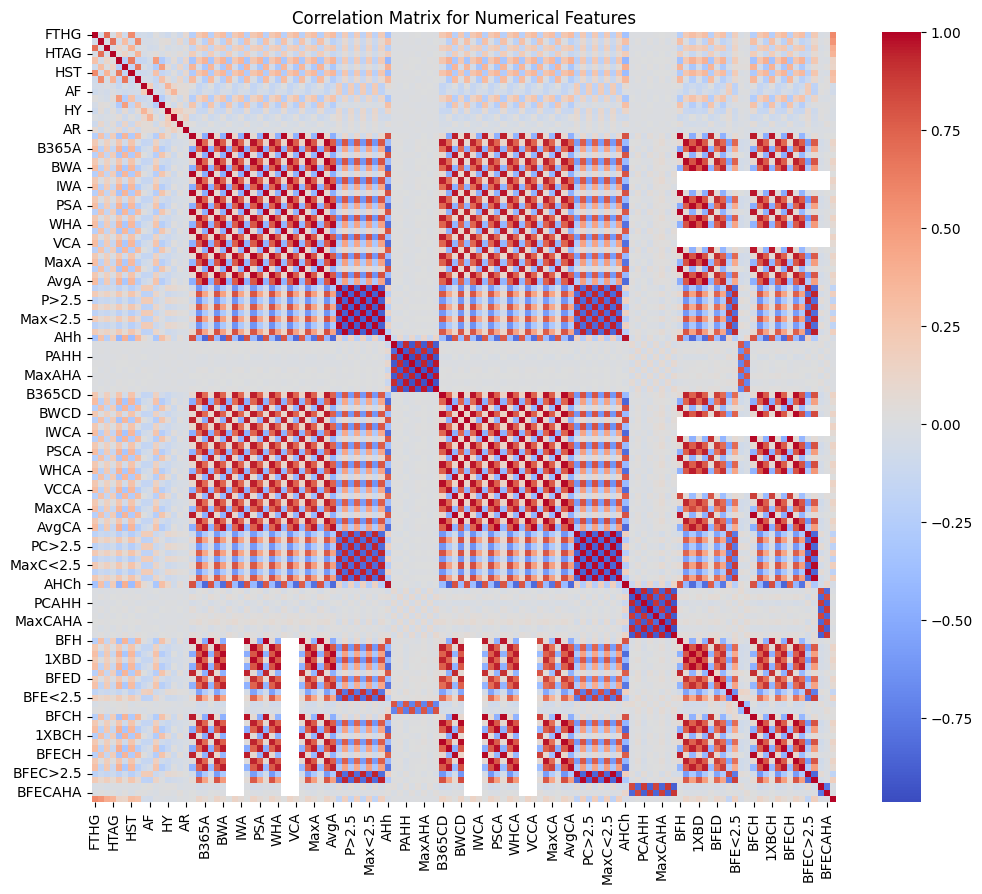

In [28]:
# Plot a correlation matrix for numerical features
numerical_data = full_data.select_dtypes(include=[np.number])
correlation_matrix = numerical_data.corr()

# Incase we want to filter for high correlations only, we can use the following line >
# correlation_matrix = correlation_matrix[correlation_matrix.abs() > 0.9]
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=False, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix for Numerical Features")
plt.show()

The matrix is super cluttered and details are absolutely unreadable, but we can still makeout that there are highly correlated columns (we suspect these to be the odds in individual betting agencies).

## First thoughts on encoding

In [12]:
# Let's see how many unique teams we have in the dataset
union_teams = set(limited_data['HomeTeam']).union(set(limited_data['AwayTeam']))
# Sets only allow unique values and union combines both sets, so this gives us all unique teams

print(f"Total unique teams: {len(union_teams)}")

Total unique teams: 478


There are 478 teams in total in our dataset, which is not a small number. One-hot encoding both columns would push our dataset to almost a 1000 features and would make it very sparse. If we decide to use target encoding, there is a pretty good chance that some new teams might appear in the test set, so we might have to encode before splitting into the train and test sets. This is definitely a risk of data leakage.

## Enhancing the limited dataset

In [13]:
limited_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42593 entries, 0 to 42592
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Div       42593 non-null  object
 1   Date      42593 non-null  object
 2   Time      42593 non-null  object
 3   HomeTeam  42593 non-null  object
 4   AwayTeam  42593 non-null  object
 5   FTHG      42593 non-null  int64 
 6   FTAG      42593 non-null  int64 
 7   FTR       42593 non-null  object
 8   Season    42593 non-null  object
dtypes: int64(2), object(7)
memory usage: 2.9+ MB


Let's ensure that the `Date` and `Time` columns are in the correct format :)


In [14]:
# These are the types we want
desired_date_type = datetime.date
desired_time_type = datetime.time

# The if statements ensure that the code can be run multiple times without error
# If the types are already correct, no conversion is done
# If the types are incorrect, we convert them into the desired types and print a message :)
if type(limited_data["Date"].iloc[0]) != desired_date_type:
    print(f"Changing 'Date' column from {type(limited_data['Date'].iloc[0])} to {desired_date_type}")
    limited_data["Date"] = pd.to_datetime(limited_data["Date"], format="%d/%m/%Y").dt.date

if type(limited_data["Time"].iloc[0]) != desired_time_type:
    print(f"Changing 'Time' column from {type(limited_data['Time'].iloc[0])} to {desired_time_type}")
    limited_data["Time"] = pd.to_datetime(limited_data["Time"], format="%H:%M").dt.time

# Double check the types, this prints even if no changes were made
print(f"Current column types:\nDate: {type(limited_data['Date'].iloc[0])},\nTime: {type(limited_data['Time'].iloc[0])}")

Changing 'Date' column from <class 'str'> to <class 'datetime.date'>
Changing 'Time' column from <class 'str'> to <class 'datetime.time'>
Current column types:
Date: <class 'datetime.date'>,
Time: <class 'datetime.time'>


Triple baaam! 💥💥💥

OK. Now, that the dates are acutally in a date format, let's look if the season start dates and end dates look correct.

### Season range check

In [15]:
seasons = limited_data["Season"].unique()
for season in seasons:
    min_date = limited_data[limited_data["Season"] == season]["Date"].min()
    max_date = limited_data[limited_data["Season"] == season]["Date"].max()
    print(f"Season: {season}, Date Range: {min_date} to {max_date}")

Season: 1920, Date Range: 2019-07-26 to 2020-08-07
Season: 2021, Date Range: 2020-08-01 to 2021-05-30
Season: 2122, Date Range: 2021-07-23 to 2022-05-29
Season: 2223, Date Range: 2022-07-15 to 2023-06-07
Season: 2324, Date Range: 2023-07-28 to 2024-06-02
Season: 2425, Date Range: 2024-07-26 to 2025-06-01


We do see some overlap, but that might occur due to differences between countries.

### Target variable

Let's create the target variable, which will equal to 1 for matches ending with 3 or more goals and 0 for the ones ending with 2 or less.

In [16]:
limited_data["Target"] = [1 if i > 2.5 else 0 for i in np.add(limited_data["FTHG"],limited_data["FTAG"])]
limited_data.head()

,Div,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,Season,Target
0,B1,2019-07-26,19:30:00,Genk,Kortrijk,2,1,H,1920,1
1,B1,2019-07-27,17:00:00,Cercle Brugge,Standard,0,2,A,1920,0
2,B1,2019-07-27,19:00:00,St Truiden,Mouscron,0,1,A,1920,0
3,B1,2019-07-27,19:00:00,Waregem,Mechelen,0,2,A,1920,0
4,B1,2019-07-27,19:30:00,Waasland-Beveren,Club Brugge,1,3,A,1920,1


In [17]:
full_data["Target"] = [1 if i > 2.5 else 0 for i in np.add(full_data["FTHG"],full_data["FTAG"])]
full_data.head()

,Div,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,...,1XBCA,BFECH,BFECD,BFECA,BFEC>2.5,BFEC<2.5,BFECAHH,BFECAHA,Referee,Target
0,B1,26/07/2019,19:30,Genk,Kortrijk,2,1,H,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,B1,27/07/2019,17:00,Cercle Brugge,Standard,0,2,A,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,B1,27/07/2019,19:00,St Truiden,Mouscron,0,1,A,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,B1,27/07/2019,19:00,Waregem,Mechelen,0,2,A,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,B1,27/07/2019,19:30,Waasland-Beveren,Club Brugge,1,3,A,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


## Feature engineering

Just jotting ideas down: 
- add a TimeOfDay column with 0 being 00:00 and 1 being 23:59, so we can model the deppendency on time
- add a SeasonProgress column with 0 being the first day of season and 1 being the last day of season
- add a column with the FTHF value for the last home team's match and another with the FTAG for the away team's last match
- maybe add a column that shows remaining matches in the season for each team?
    - my reasoning behind this is that last matches in the season could be more competetive resulting in more / less goals
- would it be possible to compute team's position in the league ranking?